<a href="https://colab.research.google.com/github/jmmzhng-pro/DSCI_631_Project/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**DSCI 631 Final Project**

- Group member
    - Name: Jonathan Watkins
    - Email: jfw68@drexel.edu
- Group member
    - Name: Jake Jarosik
    - Email: jj3268@drexel.edu
- Group member
    - Name: Jimmy Zhang
    - Email: jz876@drexel.edu


##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 01. Time series forecasting (TensorFlow Tutorial modified to process our dataset)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections:

* Forecast for a single time step:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [1]:
# Comment in and out as need
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
#function to convert to pandas of string of time to date
from dateutil import parser
from datetime import datetime

def transform_to_date(pandas_object, col_name=''):
  if col_name == '':
    pandas_object = pandas_object.apply(parser.parse).apply(datetime.date)
    return pandas_object
  else:
    pandas_object[col_name] = pandas_object['col_name'].apply(parser.parse).apply(datetime.date)
    return pandas_object[col_name]

## Importing the prepared dataset

In [4]:
df = pd.read_csv('/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/CompliedDataset_LVCF_Imputation_Prepared.csv', index_col='Unnamed: 0')

#Subset df to non-null
df = df.dropna()

#seperate date values
date_time = transform_to_date(df['ds'])
date_time = df.pop('ds')

#Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)

Let's take a glance at the data. Here are the first few rows:

In [5]:
df.head()

,y,AAPL_Open,MSFT_Open,AMZN_Open,NVDA_Open,GOOGL_Open,GOOG_Open,TSLA_Open,UNH_Open,LLY_Open,...,Total Interest-bearing Debt,Total Marketable,Total Non-marketable,Treasury Bills,Treasury Bonds,Treasury Inflation-Protected Securities (TIPS),Treasury Notes,United States Savings Inflation Securities,United States Savings Securities,sentiment
776,0.050547,0.003110,0.007895,0.002504,0.005639,0.023268,0.023047,0.000369,0.000000,0.000601,...,0.930834,0.544194,0.971376,0.028117,1.0,0.985697,1.0,0.168522,0.001199,0.650601
777,0.056354,0.004004,0.007958,0.002604,0.005790,0.023427,0.023205,0.000411,0.000540,0.000589,...,0.930834,0.544194,0.971376,0.028117,1.0,0.985697,1.0,0.168522,0.001199,0.650601
778,0.055391,0.004517,0.008234,0.002855,0.005882,0.024596,0.024363,0.000387,0.001143,0.001003,...,0.930834,0.544194,0.971376,0.028117,1.0,0.985697,1.0,0.168522,0.001199,0.650601
779,0.056222,0.004411,0.008319,0.003436,0.006475,0.024323,0.024093,0.000332,0.001206,0.001169,...,0.930834,0.544194,0.971376,0.028117,1.0,0.985697,1.0,0.168522,0.001199,0.650601
780,0.057241,0.004385,0.007746,0.003575,0.006397,0.024444,0.024212,0.000270,0.003381,0.001583,...,0.930834,0.544194,0.971376,0.028117,1.0,0.985697,1.0,0.168522,0.001199,0.650601


In [6]:
df.columns

Index(['y', 'AAPL_Open', 'MSFT_Open', 'AMZN_Open', 'NVDA_Open', 'GOOGL_Open',
       'GOOG_Open', 'TSLA_Open', 'UNH_Open', 'LLY_Open',
       ...
       'Total Interest-bearing Debt', 'Total Marketable',
       'Total Non-marketable', 'Treasury Bills', 'Treasury Bonds',
       'Treasury Inflation-Protected Securities (TIPS)', 'Treasury Notes',
       'United States Savings Inflation Securities',
       'United States Savings Securities', 'sentiment'],
      dtype='object', length=132)

Here is the evolution of a few features over time:

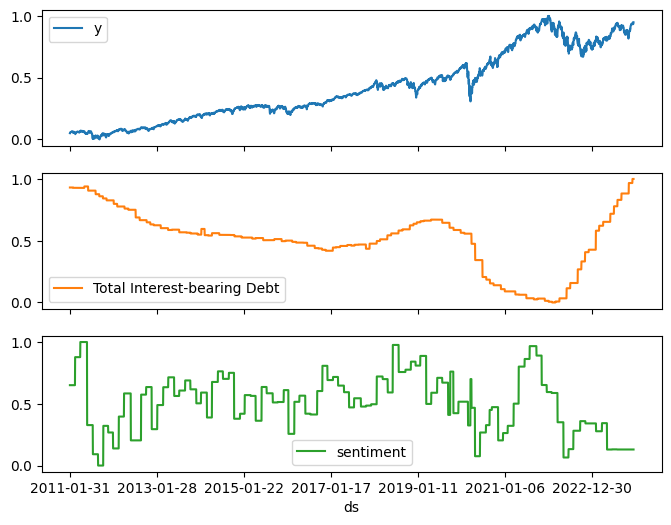

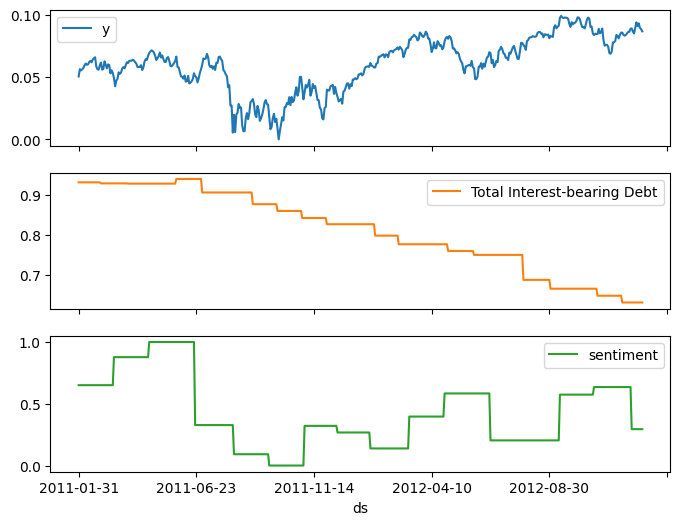

In [7]:
plot_cols = ['y', 'Total Interest-bearing Debt', 'sentiment']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Split the data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [9]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [10]:
test_df

,y,AAPL_Open,MSFT_Open,AMZN_Open,NVDA_Open,GOOGL_Open,GOOG_Open,TSLA_Open,UNH_Open,LLY_Open,...,Total Interest-bearing Debt,Total Marketable,Total Non-marketable,Treasury Bills,Treasury Bonds,Treasury Inflation-Protected Securities (TIPS),Treasury Notes,United States Savings Inflation Securities,United States Savings Securities,sentiment
3689,0.800153,0.858290,0.704470,0.717261,0.351900,0.737926,0.742581,0.721866,0.960513,0.497560,...,0.157725,0.155402,0.070175,0.190159,0.002017,0.000000,0.090056,0.899786,0.540168,0.281717
3690,0.792837,0.808045,0.668657,0.680139,0.315155,0.703992,0.706667,0.686258,0.929759,0.480512,...,0.157725,0.155402,0.070175,0.190159,0.002017,0.000000,0.090056,0.899786,0.540168,0.281717
3691,0.780815,0.813272,0.670876,0.687675,0.313954,0.705283,0.708452,0.698550,0.938100,0.475190,...,0.157725,0.155402,0.070175,0.190159,0.002017,0.000000,0.090056,0.899786,0.540168,0.281717
3692,0.772387,0.803564,0.667411,0.677627,0.302433,0.708727,0.712736,0.680868,0.919961,0.470201,...,0.268261,0.266898,0.116805,0.356271,0.000000,0.023242,0.146341,0.976124,0.570144,0.281717
3693,0.775592,0.783989,0.649762,0.658369,0.278930,0.691724,0.695386,0.661259,0.917143,0.459989,...,0.268261,0.266898,0.116805,0.356271,0.000000,0.023242,0.146341,0.976124,0.570144,0.281717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4008,0.938664,0.969175,0.959851,0.765826,0.917216,0.846687,0.853136,0.571433,0.994031,0.939825,...,1.000000,1.000000,0.403047,1.000000,0.029926,0.122169,0.795497,0.383191,0.982614,0.129948
4009,0.937961,0.970410,0.952594,0.756337,0.905063,0.840015,0.846538,0.566848,0.995653,0.941762,...,1.000000,1.000000,0.403047,1.000000,0.029926,0.122169,0.795497,0.383191,0.982614,0.129948
4010,0.933135,0.993190,0.972011,0.778833,0.940083,0.857879,0.864602,0.588920,0.992678,0.954326,...,1.000000,1.000000,0.403047,1.000000,0.029926,0.122169,0.795497,0.383191,0.982614,0.129948
4011,0.942940,0.988785,0.957468,0.770850,0.909749,0.883706,0.891020,0.585579,1.000000,0.950183,...,1.000000,1.000000,0.403047,1.000000,0.029926,0.122169,0.795497,0.383191,0.982614,0.129948


## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data.

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both.

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

- *Single-output*, and *multi-output* predictions.
- *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

  ![One prediction 24 hours into the future.](images/raw_window_24h.png)

2. A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:

  ![One prediction one hour into the future.](images/raw_window_1h.png)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

In [11]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [12]:
w1 = WindowGenerator(input_width=365, label_width=30, shift=1,
                     label_columns=['y'])
w1

Total window size: 366
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [13]:
w2 = WindowGenerator(input_width=31, label_width=5, shift=1,
                     label_columns=['y'])
w2

Total window size: 32
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
Label indices: [27 28 29 30 31]
Label column name(s): ['y']

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](images/split_window.png)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [14]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [15]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 32, 132)
Inputs shape: (3, 31, 132)
Labels shape: (3, 5, 1)


Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 19 features at each time step. It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially, this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [16]:
w2.example = example_inputs, example_labels

In [17]:
def plot(self, model=None, plot_col='y', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Market Days')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

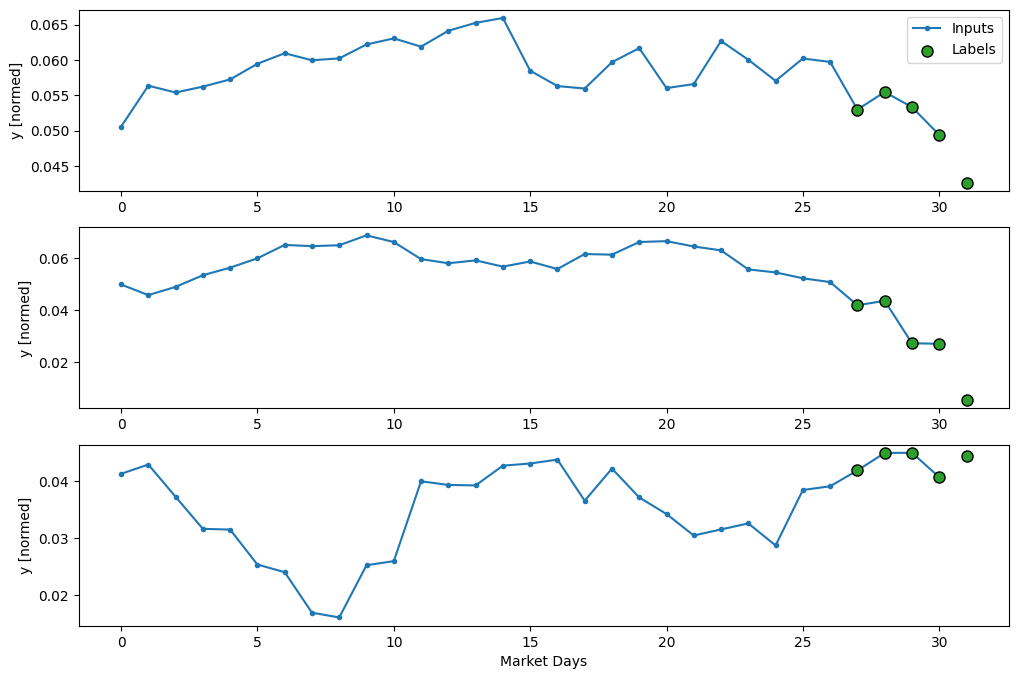

In [18]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

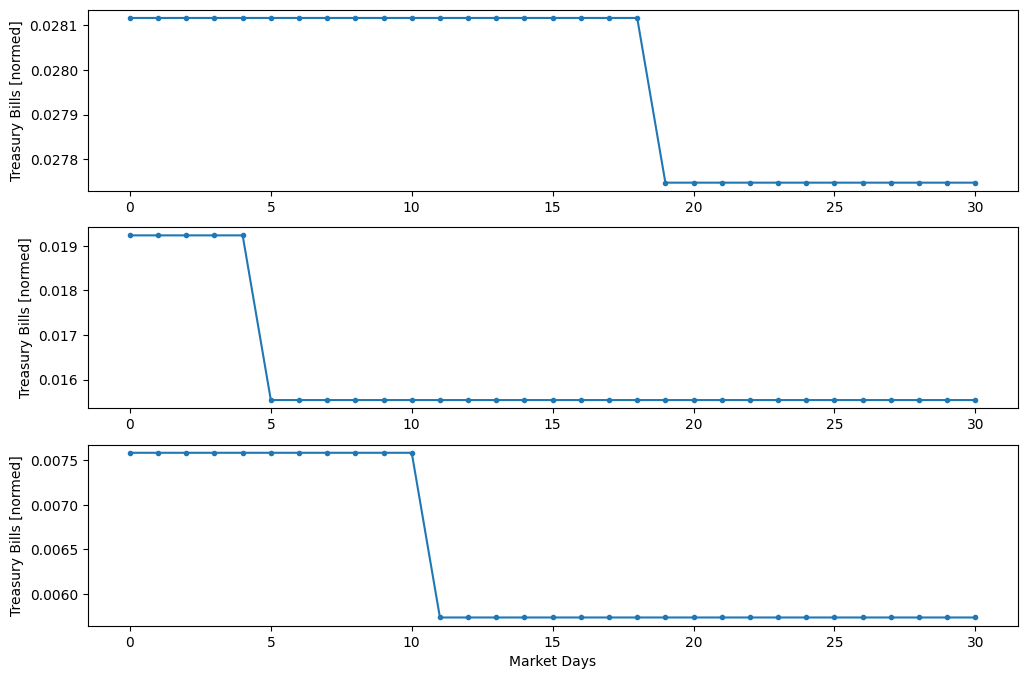

In [19]:
w2.plot(plot_col='Treasury Bills')

### 4. Create `tf.data.Dataset`s

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

In [20]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [21]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [22]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 31, 132), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [23]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 31, 132)
Labels shape (batch, time, features): (32, 5, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step (one hour) into the future based only on the current conditions.

So, start by building models to predict the `T (degC)` value one hour into the future.

![Predict the next time step](images/narrow_window.png)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [24]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['y'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['y']

The `window` object creates `tf.data.Dataset`s from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [25]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 132)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature one hour into the future, given the current value of all features. The current values include the current temperature.

So, start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](images/baseline.png)

In [26]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [27]:
baseline = Baseline(label_index=column_indices['y'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

21/21 [==============================] - 1s 2ms/step - loss: 2.1174e-04 - mean_absolute_error: 0.0103


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample.

So, create a wider `WindowGenerator` that generates windows 24 hours of consecutive inputs and labels at a time. The new `wide_window` variable doesn't change the way the model operates. The model still makes predictions one hour into the future based on a single input time step. Here, the `time` axis acts like the `batch` axis: each prediction is made independently with no interaction between time steps:

In [28]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['y'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['y']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:

![One prediction 1h into the future, ever hour.](images/last_window.png)

In [29]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 132)
Output shape: (32, 24, 1)


By plotting the baseline model's predictions, notice that it is simply the labels shifted right by one hour:

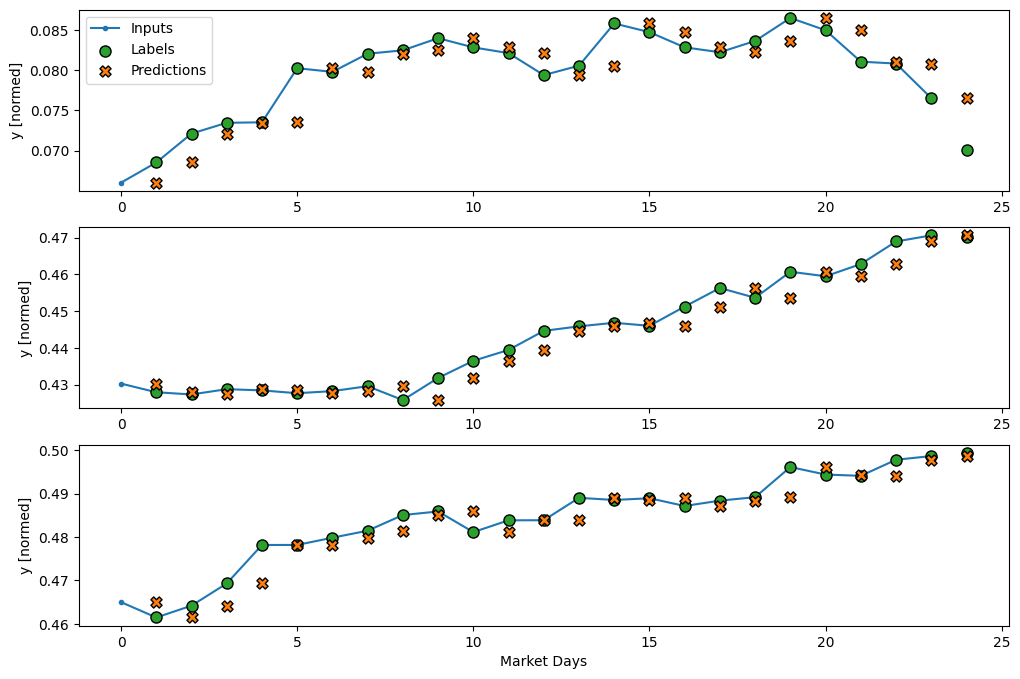

In [30]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24 hours. This deserves some explanation:

- The blue `Inputs` line shows the input temperature at each time step. The model receives all features, this plot only shows the temperature.
- The green `Labels` dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
- The orange `Predictions` crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the `Labels`.

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](images/narrow_window.png)

A `tf.keras.layers.Dense` layer with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`; it is applied independently to every item across the `batch` and `time` axes.

In [31]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [32]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 132)
Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

In [33]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

In [34]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
71/71 [==============================] - 1s 5ms/step - loss: 0.0551 - mean_absolute_error: 0.1756 - val_loss: 0.9504 - val_mean_absolute_error: 0.8753
Epoch 2/20
71/71 [==============================] - 0s 4ms/step - loss: 0.0145 - mean_absolute_error: 0.0947 - val_loss: 1.0985 - val_mean_absolute_error: 0.9409
Epoch 3/20
21/21 [==============================] - 0s 2ms/step - loss: 1.0849 - mean_absolute_error: 0.9358


Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](images/wide_window.png)

In [35]:
len(list(wide_window.train))

71

In [36]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 132)
Output shape: (32, 24, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

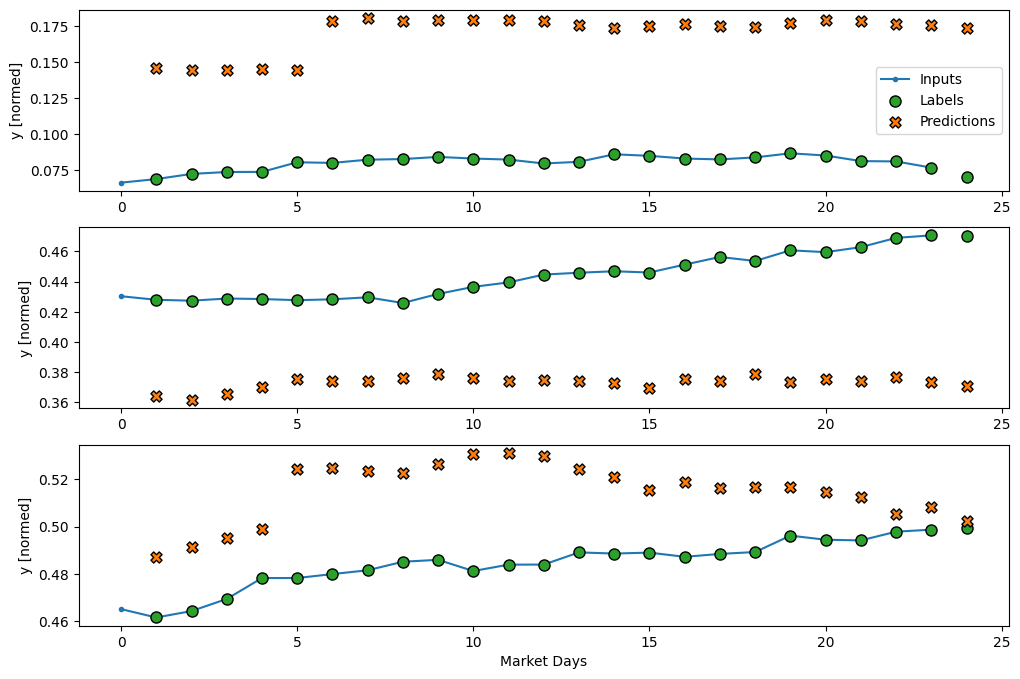

In [37]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights and visualize the weight assigned to each input:

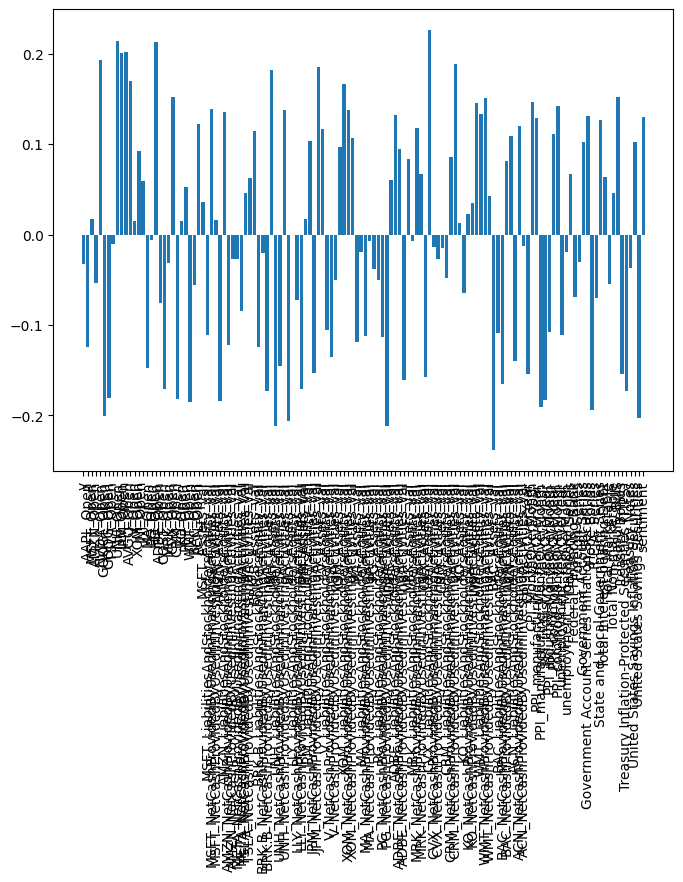

In [38]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `T (degC)`. This is one of the risks of random initialization.

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output:

In [39]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
71/71 [==============================] - 2s 7ms/step - loss: 0.0601 - mean_absolute_error: 0.1270 - val_loss: 0.1911 - val_mean_absolute_error: 0.4045
Epoch 2/20
71/71 [==============================] - 0s 5ms/step - loss: 7.6460e-04 - mean_absolute_error: 0.0209 - val_loss: 0.1283 - val_mean_absolute_error: 0.3250
Epoch 3/20
71/71 [==============================] - 0s 5ms/step - loss: 4.2447e-04 - mean_absolute_error: 0.0160 - val_loss: 0.1008 - val_mean_absolute_error: 0.2830
Epoch 4/20
71/71 [==============================] - 0s 5ms/step - loss: 3.2455e-04 - mean_absolute_error: 0.0141 - val_loss: 0.0943 - val_mean_absolute_error: 0.2717
Epoch 5/20
71/71 [==============================] - 0s 5ms/step - loss: 2.5417e-04 - mean_absolute_error: 0.0123 - val_loss: 0.0872 - val_mean_absolute_error: 0.2591
Epoch 6/20
71/71 [==============================] - 0s 5ms/step - loss: 2.1748e-04 - mean_absolute_error: 0.0114 - val_loss: 0.0849 - val_mean_absolute_error: 0.2550
Epoch 7/

### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](images/conv_window.png)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of three-hour inputs and one-hour labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [40]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['y'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['y']

Text(0.5, 1.0, 'Given 3 values of inputs, predict 1 day into the future.')

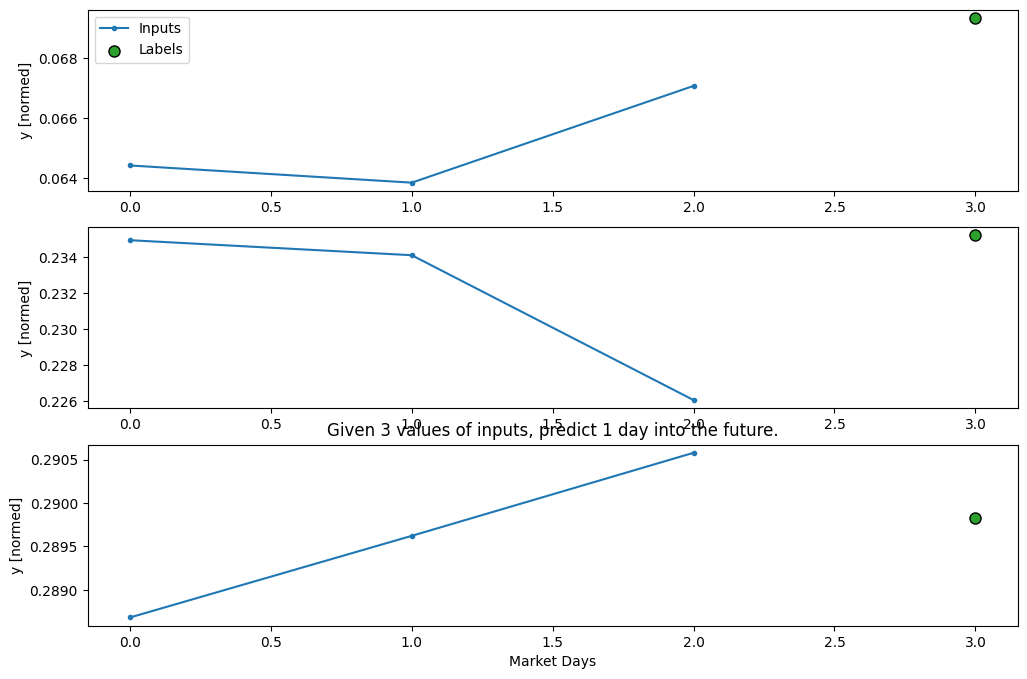

In [41]:
conv_window.plot()
plt.title("Given 3 values of inputs, predict 1 day into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `tf.keras.layers.Flatten` as the first layer of the model:

In [42]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [43]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 132)
Output shape: (32, 1, 1)


In [44]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

21/21 [==============================] - 0s 2ms/step - loss: 0.0143 - mean_absolute_error: 0.1028


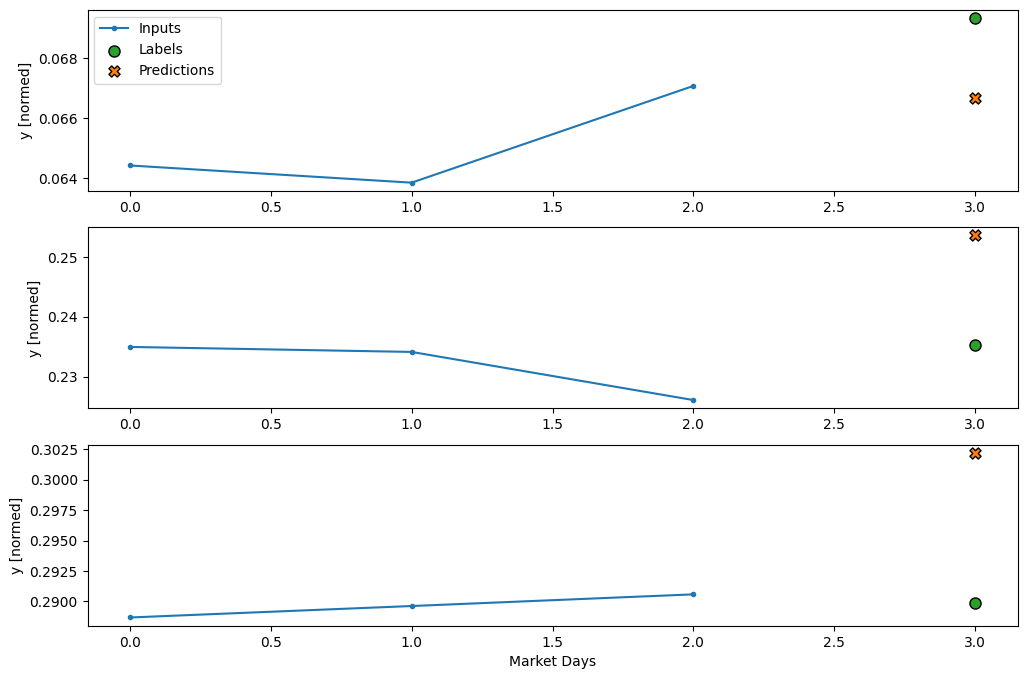

In [45]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape.

The convolutional models in the next section fix this problem.

### Convolution neural network

A convolution layer (`tf.keras.layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution.

Note the changes:
* The `tf.keras.layers.Flatten` and the first `tf.keras.layers.Dense` are replaced by a `tf.keras.layers.Conv1D`.
* The `tf.keras.layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [46]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to check that the model produces outputs with the expected shape:

In [47]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 132)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [48]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

21/21 [==============================] - 0s 3ms/step - loss: 0.0100 - mean_absolute_error: 0.0836


The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](images/wide_conv_window.png)

If you run it on wider input, it produces wider output:

In [49]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 132)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match:

In [50]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['y'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['y']

In [51]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 132)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now, you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding time steps:

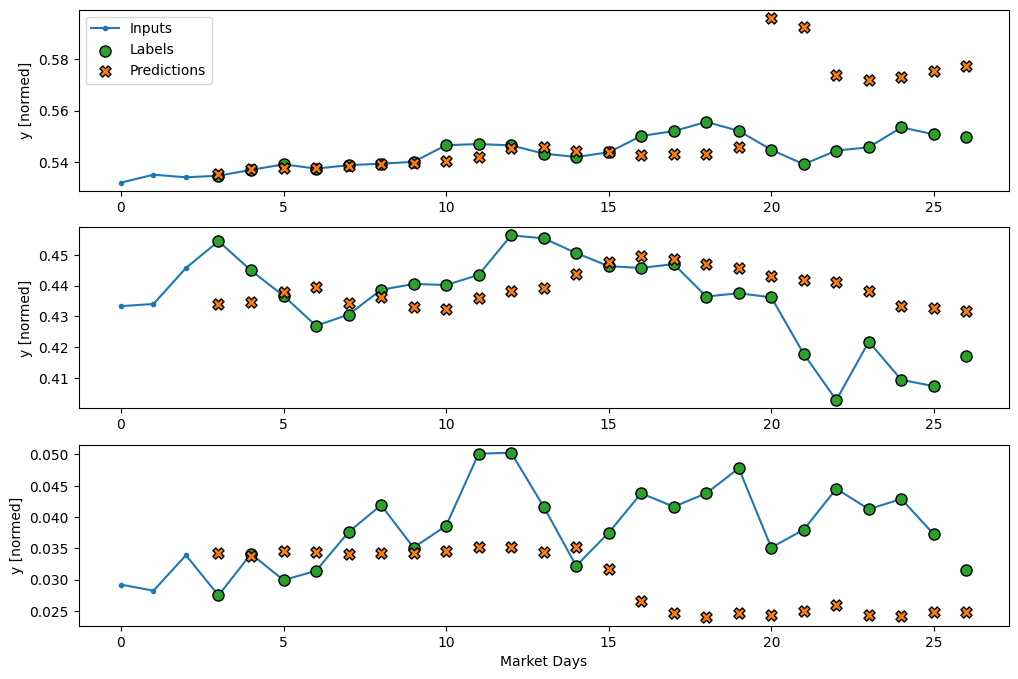

In [52]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

You can learn more in the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial and the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide.

In this tutorial, you will use an RNN layer called Long Short-Term Memory (`tf.keras.layers.LSTM`).

An important constructor argument for all Keras RNN layers, such as `tf.keras.layers.LSTM`, is the `return_sequences` argument. This setting can configure the layer in one of two ways:

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction:

![An LSTM warming up and making a single prediction](images/lstm_1_window.png)

2. If `True`, the layer returns an output for each input. This is useful for:
  * Stacking RNN layers.
  * Training a model on multiple time steps simultaneously.

![An LSTM making a prediction after every time step](images/lstm_many_window.png)

In [53]:
BATCH_SIZE = 5

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True, batch_size=BATCH_SIZE),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True`, the model can be trained on 24 hours of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first time step, the model has no access to previous steps and, therefore, can't do any better than the simple `linear` and `dense` models shown earlier.

In [54]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 132)
Output shape: (32, 24, 1)


In [55]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test)

10/10 [==============================] - 0s 3ms/step - loss: 0.0217 - mean_absolute_error: 0.1402


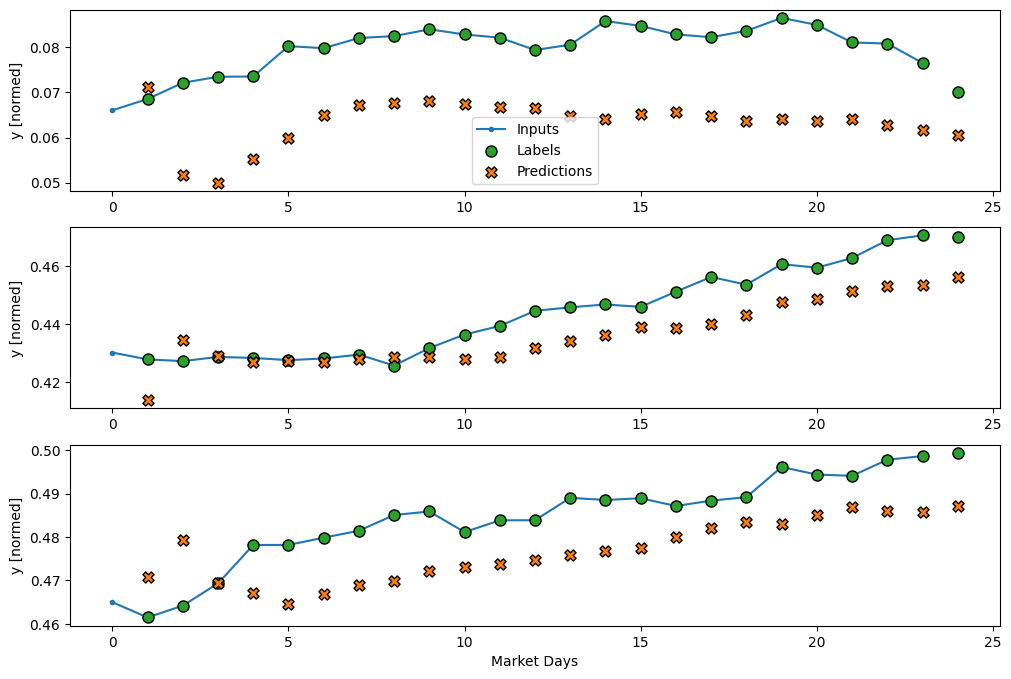

In [56]:
wide_window.plot(lstm_model)

### Performance

With this dataset typically each of the models does slightly better than the one before it:

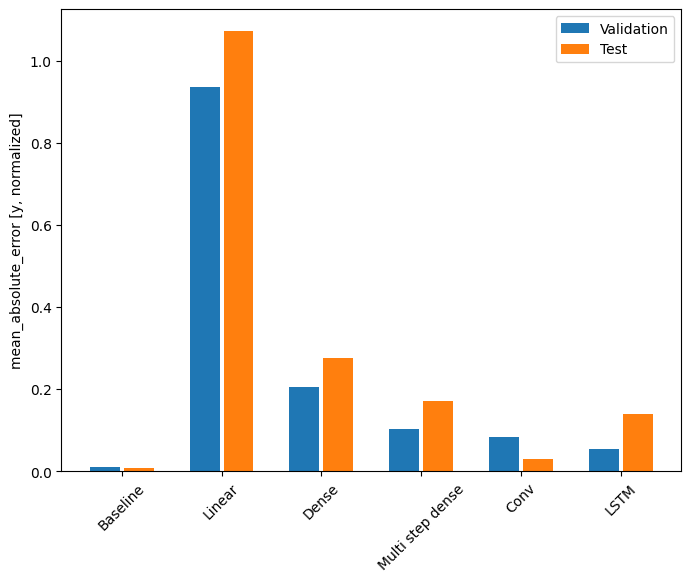

In [57]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [y, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [58]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0088
Linear      : 1.0709
Dense       : 0.2769
Multi step dense: 0.1720
Conv        : 0.0305
LSTM        : 0.1402


# 02. Customize the Above Code for Time Series Split

In [120]:
#define LSTM model
BATCH_SIZE = 1
MAX_EPOCHS = 20

lstm_model = Sequential([LSTM(4,input_shape=(15,132), return_sequences=True, batch_size=BATCH_SIZE),Dense(units=1)])

In [121]:
#splitting time series
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

#initialize Time Series Train Test Split
tscv = TimeSeriesSplit(n_splits=4)

#initalize list to hold train test val info
modelMetrics = list()

for i, (train_i,test_i) in enumerate(tscv.split(df)):

  #Use indexes to grab the correct data for this split, create validation subset from train_df_i
  original_train_len = len(train_i)
  new_train_len = int(original_train_len*0.7)
  new_train_i = train_i[:new_train_len]
  val_i = train_i[new_train_len:]
  train_df_i=df.copy().iloc[new_train_i,:]
  val_df_i=df.copy().iloc[val_i,:]
  test_df_i=df.copy().iloc[test_i,:]

  #define window
  my_window = WindowGenerator(input_width=15, label_width=15, shift=1,
                              label_columns=['y'],
                              train_df=train_df_i, val_df=val_df_i, test_df=test_df_i)

  #compile and fit
  history = compile_and_fit(lstm_model, my_window)
  IPython.display.clear_output()

  # make predictions
  #val_predictions = lstm_model.predict(val_df_i[[col for col in train_df_i if col != 'y']])
  #test_predictions = lstm_model.predict(test_df_i[[col for col in train_df_i if col != 'y']])

  # calculate root mean squared error
  #val_rmse = np.sqrt(mean_squared_error(val_df_i['y'],val_predictions))
  #test_rmse = np.sqrt(mean_squared_error(test_df_i['y'],test_predictions))

  # Mean Absolute Error (MAE)
  #val_mae = mean_absolute_error(val_df_i['y'],val_predictions)
  #test_mae = mean_absolute_error(test_df_i['y'],test_predictions)

  #store metrics
  validation_performance = lstm_model.evaluate(wide_window.val)
  test_performance = lstm_model.evaluate(wide_window.test)
  modelMetrics.append((validation_performance, test_performance, history))


10/10 [==============================] - 0s 3ms/step - loss: 0.0341 - mean_absolute_error: 0.1778


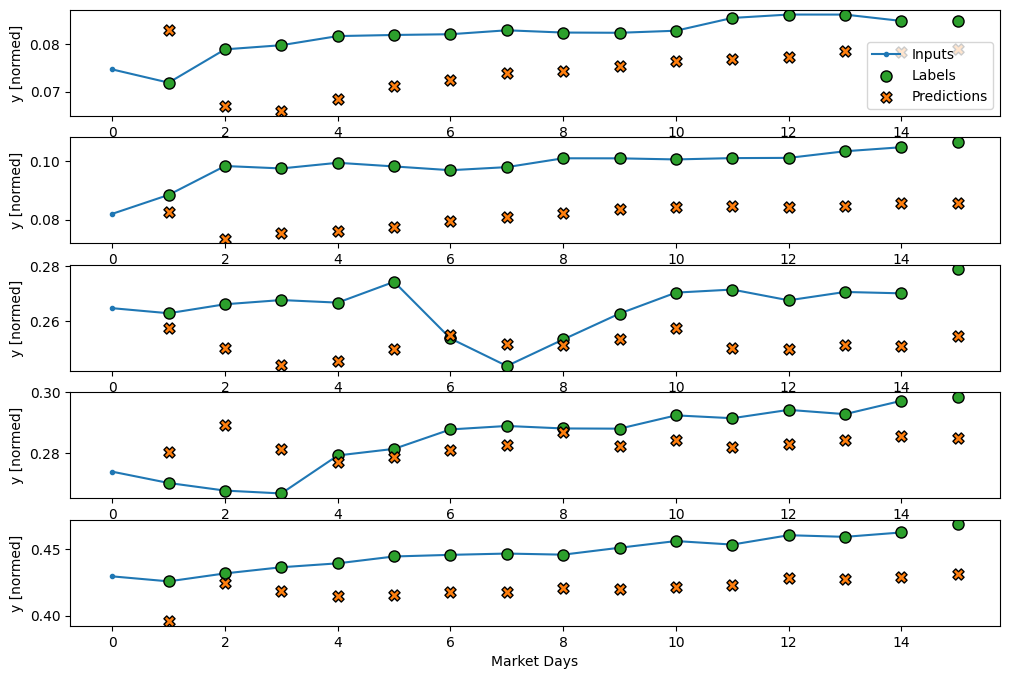

In [122]:
#plot
my_window.plot(lstm_model, max_subplots=5)

<ipython-input-123-9a437cf42392>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Validation', 'Test'])


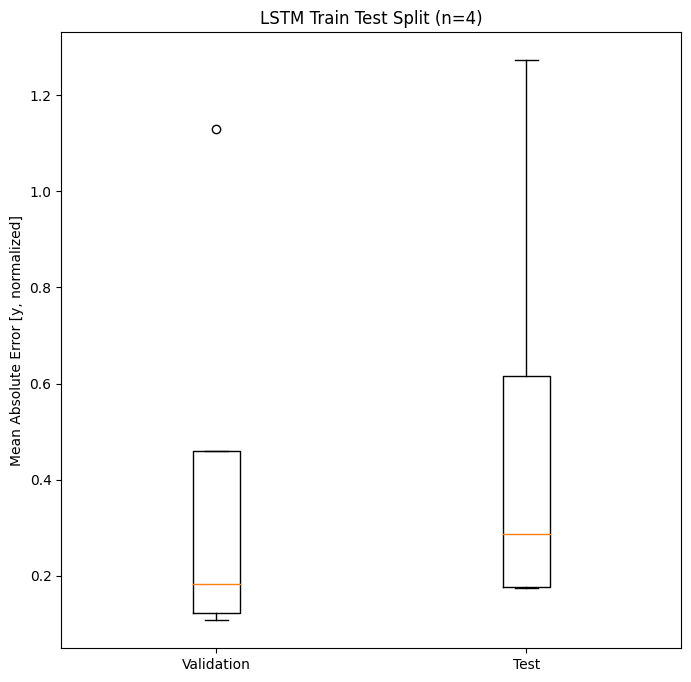

In [123]:
#plot
val_mae = [v[0][1] for v in modelMetrics]
test_mae = [v[1][1] for v in modelMetrics]

fig = plt.figure(figsize =(8, 8))
ax = fig.add_subplot(111)
ax.set_xticklabels(['Validation', 'Test'])
plt.title("LSTM Train Test Split (n=4)")
plt.ylabel('Mean Absolute Error [y, normalized]')
plt.boxplot([val_mae, test_mae])
plt.show()

# 03. Additional Model Tuning

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
import datetime as dt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,accuracy_score, precision_score,f1_score
from sklearn.model_selection import TimeSeriesSplit

In [106]:
#Load compiled dataset
dataset = pd.read_csv('/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/CompliedDataset_LVCF_Imputation_Prepared.csv')

In [107]:
def filter_dataset(dataset):
  numeric_cols = dataset.select_dtypes(include='number').columns.tolist()
  dataset = dataset[numeric_cols]
  return dataset

In [108]:
#Use the minmaxscaler to rescale the data from 0 to 1 for use of the activation functions
MMscaler = MinMaxScaler(feature_range=(0,1))
dataset_date = dataset['ds']
dataset = dataset.drop(dataset.columns[[0]],axis=1)
dataset = filter_dataset(dataset)
dataset_cols = dataset.columns
dataset = MMscaler.fit_transform(dataset)
dataset = pd.DataFrame(dataset,columns=dataset_cols)
dataset= dataset.fillna(0)
dataset = dataset.set_index(dataset_date)

In [109]:
tscv = TimeSeriesSplit(n_splits=5)
x_dataset = dataset.drop(['y'],axis=1)
y_dataset = pd.DataFrame(dataset['y'])
for train_index, test_index in tscv.split(x_dataset):
  X_train, X_test = x_dataset.iloc[train_index], x_dataset.iloc[test_index]
  Y_train, Y_test = y_dataset.iloc[train_index], y_dataset.iloc[test_index]

In [110]:
lstm_model = Sequential([LSTM(4,input_shape=(131,1)),Dense(units=1)])
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
history = lstm_model.fit(X_train, Y_train, epochs=50, batch_size=1)

Epoch 1/50
3345/3345 [==============================] - 20s 6ms/step - loss: 0.0146
Epoch 2/50
3345/3345 [==============================] - 19s 6ms/step - loss: 0.0033
Epoch 3/50
3345/3345 [==============================] - 19s 6ms/step - loss: 0.0029
Epoch 4/50
3345/3345 [==============================] - 20s 6ms/step - loss: 0.0025
Epoch 5/50
3345/3345 [==============================] - 19s 6ms/step - loss: 0.0020
Epoch 6/50
3345/3345 [==============================] - 19s 6ms/step - loss: 0.0015
Epoch 7/50
3345/3345 [==============================] - 19s 6ms/step - loss: 0.0013
Epoch 8/50
3345/3345 [==============================] - 19s 6ms/step - loss: 0.0011
Epoch 9/50
3345/3345 [==============================] - 19s 6ms/step - loss: 9.4403e-04
Epoch 10/50
3345/3345 [==============================] - 19s 6ms/step - loss: 8.9730e-04
Epoch 11/50
3345/3345 [==============================] - 19s 6ms/step - loss: 8.6437e-04
Epoch 12/50
3345/3345 [==============================] - 19s 6

In [111]:
# make predictions
trainPredict = lstm_model.predict(X_train)
testPredict = lstm_model.predict(X_test)
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(Y_train, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(Y_test, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

21/21 [==============================] - 0s 3ms/step
Train Score: 0.02 RMSE
Test Score: 0.16 RMSE


In [112]:
train_loss = lstm_model.evaluate(X_train,Y_train)
test_loss = lstm_model.evaluate(X_test, Y_test)
print(f'Train loss: {train_loss}')
print(f'Test loss: {test_loss}')

21/21 [==============================] - 0s 3ms/step - loss: 0.0244
Train loss: 0.00047979914234019816
Test loss: 0.02438943460583687


In [113]:
# Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test, testPredict)
maetrain = mean_absolute_error(Y_train,trainPredict)
print(f'Mean Absolute Error (Train): {maetrain:.4f}')
print(f'Mean Absolute Error (Test): {mae:.4f}')

# R-squared (Coefficient of Determination)
r2 = r2_score(Y_test, testPredict)
r2train = r2_score(Y_train,trainPredict)
print(f'R-squared (Train): {r2train:.4f}')
print(f'R-squared (Test): {r2:.4f}')

Mean Absolute Error (Train): 0.0162
Mean Absolute Error (Test): 0.1364
R-squared (Train): 0.9862
R-squared (Test): -4.6953


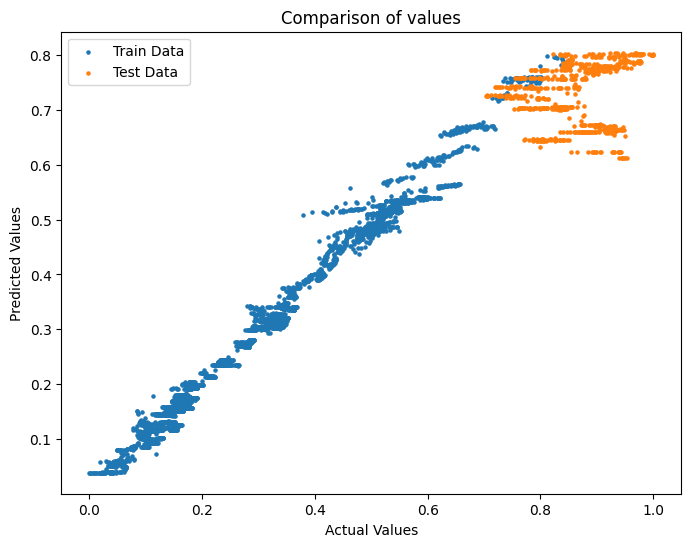

In [114]:
plt.scatter(Y_train,trainPredict,label='Train Data',s=5)
plt.scatter(Y_test,testPredict,label='Test Data',s=5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Comparison of values')
plt.legend()
plt.show()

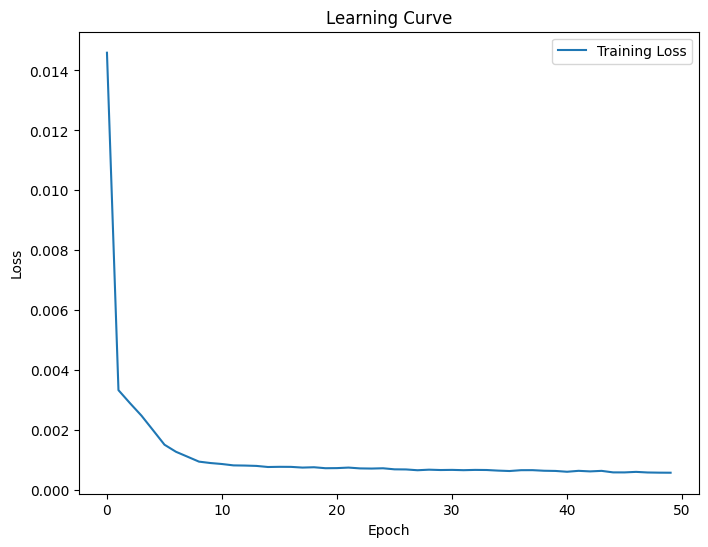

In [115]:
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

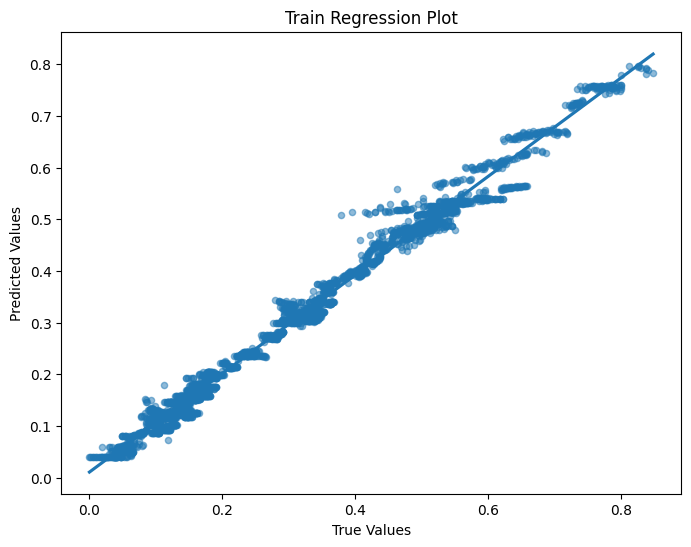

In [116]:
sns.regplot(x=Y_train, y=trainPredict, scatter_kws={'s': 20, 'alpha': 0.5})
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Train Regression Plot')
plt.show()

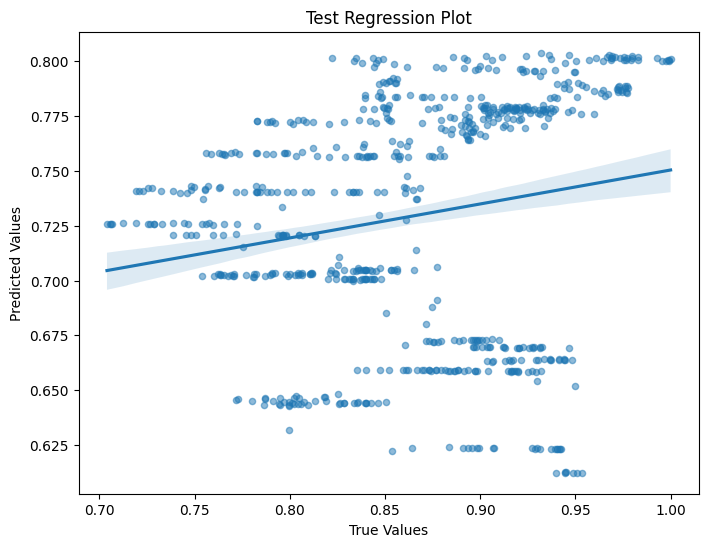

In [117]:
sns.regplot(x=Y_test, y=testPredict, scatter_kws={'s': 20, 'alpha': 0.5})
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Test Regression Plot')
plt.show()